In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

from sklearn.linear_model import LinearRegression

In [2]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'RH']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'rh']

#bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
#GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]
AK = full.loc[full['id'] == 'AK1', :].copy()

In [3]:
outlier_czs = [34105, 34113, 34112, 34106]

def subset_and_rename_A(df):
    df = df[['aum', 'frac_traveltime_lt15', 'gini',
    'rel_tot', 'cs_fam_wkidsinglemom', 'taxrate',
     'frac_worked1416', 'cs_born_foreign', 'region']]
    df.columns = ['aum', 'travel_lt15', 'gini', 
                  'rel_tot', 'single_mom', 'taxrate', 
                  'worked_14', 'foreign', 'region'] 
    return df

regions = (
    pd.read_csv('data/census_regions.csv',
                header=0, names=['state', 'stateabbrv', 'region', 'div'])
    .drop(columns=['div'])
)

cz_df = (pd.read_csv('data/mobility.csv')
         .query('not aum.isnull()', engine='python')
         .query('cz not in @outlier_czs')
         .merge(regions, on='stateabbrv')
         .pipe(subset_and_rename_A)
        )


In [4]:
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)


def make_lamorinda(sfh):
    return sfh.replace({
        'city': {
            'Lafayette': 'Lamorinda',
            'Moraga': 'Lamorinda',
            'Orinda': 'Lamorinda',
        }
    })

four_cities = ['Berkeley', 'Lamorinda', 'Piedmont', 'Richmond']

def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(dates=dates).set_index('date')


def subset(df):
    return df.loc[(df['price'] < 4000000) &
                  (df['bsqft'] < 12000) &
                  (df['lsqft'] < 100000) &
                  (df['city'].str.contains("Berkeley|Piedmont|Richmond|Lamorinda")) &
                  (df['dates'] > '2005-12-31') &
                  (df['dates'] <= '2006-12-31')
                 ]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    six_up = sfh.loc[sfh['br'] >=6, 'br'].unique()
    new_bed = sfh['br'].replace(six_up, 6)
    return sfh.assign(br=new_bed)

def compute_ppsf(sfh):
    return sfh.assign(
    ppsf=sfh['price'] / sfh['bsqft'], 
    log_ppsf=lambda df: np.log10(df['ppsf']))


sfh = (sfh_all
 .pipe(make_lamorinda)
 .pipe(parse_dates)
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
 .pipe(compute_ppsf) 
)


b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


In [5]:
var_na = ['log_price', 'log_lsqft', 'log_bsqft', 'br']

sfh = sfh.dropna(subset=var_na)

sfh.drop(["dates","county", "zip","street","year","datesold"], axis = 1, inplace=True)

# Feature Engineering for Numeric Measurements

All of the models that we have fit so far in this chapter have used numeric features that were originally provided in the data frame. In this section, we look at variables that are created from transformations of numeric features. Transforming variables to use in modeling is called *feature engineering*.

We first introduced feature engineering in {numref}`Chapters %s <ch:wrangling>` and {numref}` %s <ch:eda>`. There, we transformed features so that they had symmetric distributions.  Transformations can capture more kinds of patterns in the data and lead to better and more accurate models.

We return to the data set we used as an example in {numref}`Chapter %s <ch:eda>`: house sale prices in the San Francisco Bay area, and we restrict the data to houses sold in 2006, when sale prices were relatively stable, so we don't need to account for trends in price. 

We wish to model sale price. Recall that visualizations in  {numref}`Chapter %s <ch:eda>` showed us that sale price was related to several features, like the size of the house, size of the lot, number of bedrooms, and location. We log-transformed both sale price and the size of the house to improve their relationship, and we saw that box plots of sale price by the number of bedrooms and box plots by city revealed interesting relationships too. In this section, we include transformed numeric features into a linear model. In the next section, we also add an ordinal feature (the number of bedrooms) and a nominal feature (the city) to the model. 

We begin by modeling sale price on house size. 
The correlation matrix tell us which of our numeric explanatory variables (original and transformed) is most strongly correlated with sale price.

In [7]:
display_df(sfh.corr(), cols=9, rows=9)

,price,br,lsqft,bsqft,log_price,log_bsqft,log_lsqft,ppsf,log_ppsf
price,1.00,0.45,0.59,0.79,0.94,0.74,0.62,0.49,0.47
br,0.45,1.00,0.29,0.67,0.47,0.71,0.38,-0.18,-0.21
lsqft,0.59,0.29,1.00,0.46,0.55,0.44,0.85,0.29,0.27
bsqft,0.79,0.67,0.46,1.00,0.76,0.96,0.52,-0.08,-0.10
log_price,0.94,0.47,0.55,0.76,1.00,0.78,0.62,0.51,0.52
log_bsqft,0.74,0.71,0.44,0.96,0.78,1.00,0.52,-0.11,-0.14
log_lsqft,0.62,0.38,0.85,0.52,0.62,0.52,1.00,0.29,0.27
ppsf,0.49,-0.18,0.29,-0.08,0.51,-0.11,0.29,1.00,0.96
log_ppsf,0.47,-0.21,0.27,-0.10,0.52,-0.14,0.27,0.96,1.00


Sale price correlates most highly with house size, called `bsqft` for building square feet. We make a scatter plot of sale price against house size to confirm the association is linear.   

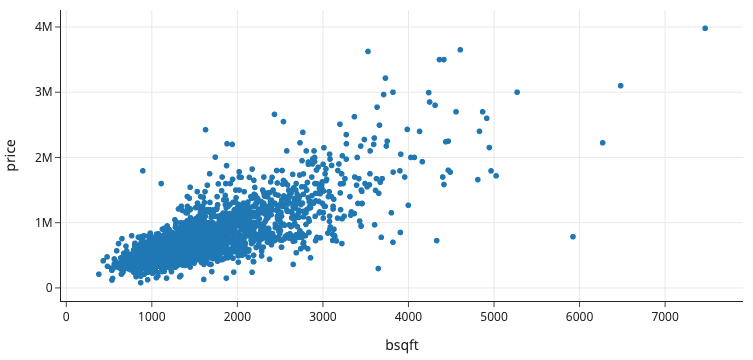

In [8]:
fig = px.scatter(sfh, x="bsqft", y="price",
                 width=350, height=250)

fig

The relationship does look roughly linear, but the very large and expensive houses are far from the center of the distribution and can overly influence the model. As shown in {numref}`Chapter %s <ch:eda>`, the log transformation makes the distributions of price and size more symmetric (both are log base 10 to make it easier to convert the values into the original units).

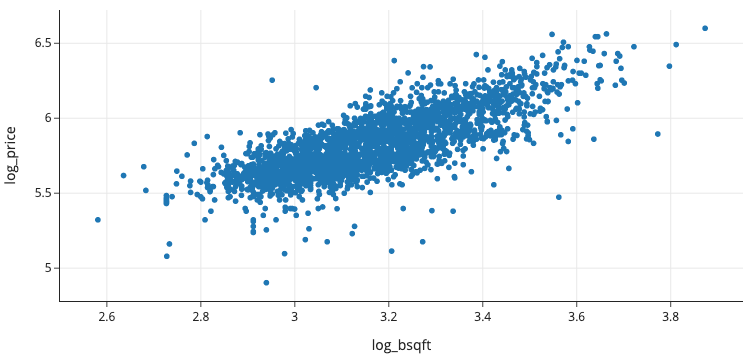

In [9]:
fig = px.scatter(sfh, x="log_bsqft", y="log_price",
                 width=350, height=250)

fig

Ideally, a model that uses transformations should make sense in the context of the data. If we fit a simple linear model based on log(size), then when we examine the coefficient, we think in terms of a percentage increase. For example, a doubling of $x$ increases the prediction by $\theta \log(2)$, since $\theta \log(2x) = \theta\log(2) + \theta \log(x)$.

Let's begin by fitting a model that explains log-transformed price by the house's log-transformed size. But first, we note that this model is still considered a linear model. If we represent sale price by $y$ and house size by $x$, then the model is

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1\log(x) 
\end{aligned}
$$

(Note that we have ignored the approximation in this equation to make the linear relationship clearer.) This equation may not seem linear, but, if we rename $\log(y)$ to $w$ and $\log(x)$ to $v$, then we can express this "log-log" relationship as a linear model in $w$ and $v$:

$$
w ~=~ \theta_0 + \theta_1 v
$$

Other examples of models that can be expressed as linear combinations of transformed features appear below.

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 x^2 \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 x z  
\end{aligned}
$$

Again, if we rename $\log(y)$ to $w$, $x^2$ to $u$, and $x z$ as $t$, then we can express each of the above models as linear in these renamed features. The above models are now, in order,  

$$
\begin{aligned}
w ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 u\\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 t \\ 
\end{aligned}
$$

In short, we can think of models that include nonlinear transformations of features and/or combinations of features as linear in their derived features. In practice, we don't rename the transformed features when we describe the model; instead, we write the model using the transformations of the original features because it's important to keep track of them, especially when interpreting the coefficients and checking residual plots.

When we refer to these models, we include mention of the transformations. That is, we call a model *log-log* when both the outcome and explanatory variables are log-transformed; we say it's *log-linear* when the outcome is log-transformed but not the explanatory variable; we describe a model as having *polynomial features* of, say degree 2, when the first and second power transformation of the explanatory variable are included; and we say a model includes an *interaction term* between two explanatory features when the product of these two features is included in the model.

Let's fit a log-log model of price on size.

In [6]:
X1_log = sfh[['log_bsqft']]    
y_log = sfh['log_price']
model1_log_log = LinearRegression().fit(X1_log, y_log)

The coefficients and predicted values from this model cannot be directly compared to a model fitted using linear features because the units are the log of dollars and log of square feet, not dollars and square feet. 

In [9]:
print(f"Model log(price) ~ log(building size):\n",
      f"Intercept (log $): {model1_log_log.intercept_:.2}\n",
      f"Coefficient of building size (log $/log ft^2): {model1_log_log.coef_[0]:.2}")

Model log(price) ~ log(building size):
 Intercept (log $): 3.0
 Coefficient of building size (log $/log ft^2): 0.9


Next, we examine the residuals and predicted values with a plot.

In [11]:
prediction = model1_log_log.predict(X1_log)
error = y_log - prediction 

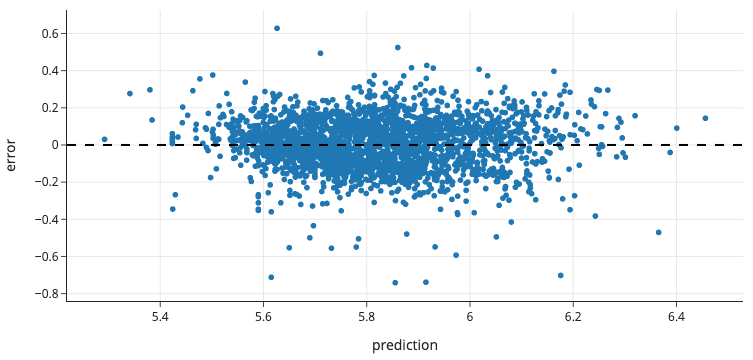

In [12]:
fig = px.scatter(x=prediction, y=error,
           labels=dict(x='prediction', y='error'),
           width=350, height=250)

fig.add_hline(0, line_color='black', line_width=2, 
              line_dash='dash', opacity=1)
fig.show()

The residual plot looks reasonable, but it contains thousands of points which makes it hard to see curvature. 

To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature, or a transformation of it. Earlier, we found that the distribution of price was related to the city where the house is located so let's examine the relationship between the residuals and city.

In [14]:
sfh = sfh.assign(errors1_log=error)

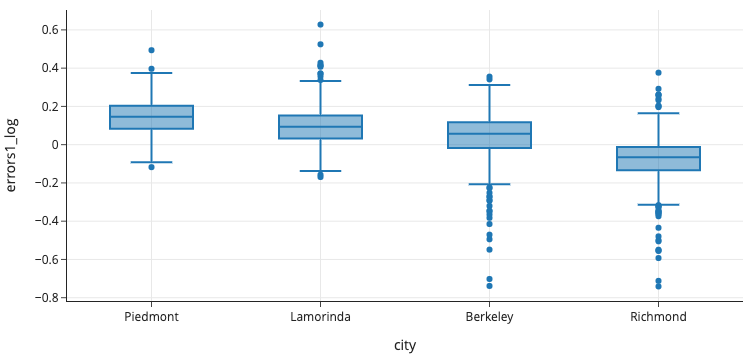

In [15]:
px.box(sfh, x='city', y='errors1_log',
       category_orders={"city":["Piedmont","Lamorinda","Berkeley", "Richmond"]},
      width=450, height=250)

This plot shows us that the distribution of errors appear shifted by city. Ideally, the median of each city's box plot lines up with 0 on the $y$-axis. Instead, more than 75%  of the houses sold in  Piedmont have positive errors, meaning the actual sale price is above the predicted value. And at the other extreme, more than 75% of sale prices in Richmond fall below their predicted values. These patterns suggest that we should include city in the model. From a context point of view, it makes sense for location to impact sale price. In the next section, we show how to incorporate a nominal variable in a linear model. 